In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde

In [17]:
from numba import vectorize, float64, guvectorize, jit

## LOAD DATASET

In [18]:
# GENERATE DATA FROM STABLE DISTRI
@jit(nopython=True)
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = np.pi / 2 * (2 * np.random.rand(num_datasets, dataset_size) - 1)
    W = - np.log(np.random.rand(num_datasets, dataset_size))
    #r = np.zeros(n)

    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        b = math.atan(const)
        s = (1 + const * const)**(1 / (2 * alpha))
        r = s * np.sin(alpha * V + b) / ((np.cos(V)) ** (1/alpha)) * (( np.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
        r = gamma * r + delta
    else:
        piover2 = np.pi / 2
        sclshftV = piover2 + beta * V
        r = 1/piover2 * (sclshftV * np.tan(V) - beta * np.log( (piover2 * W * np.cos(V) ) / sclshftV ))
        r = gamma * r + (2 / np.pi) * beta * gamma * np.log(gamma) + delta
    return r

actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 10)
actual_data

array([[ 2.78587812e+00, -9.38492791e-01, -1.12684067e-01, ...,
        -1.86274042e+00, -1.15156838e+00,  3.65195113e-04],
       [-3.45078873e+00, -4.07740588e+00, -2.12787368e+00, ...,
         1.37419792e+00,  1.54686146e+00,  1.28086861e+00],
       [-1.21707325e+00, -5.16429612e-02, -1.27637916e+00, ...,
         2.04035067e+00,  1.68718176e-01,  5.61018947e+00],
       ...,
       [-4.62549299e-01, -1.46897966e+00,  1.53172314e+00, ...,
        -1.70410993e+00, -5.11527706e-01, -1.50203750e+00],
       [ 5.79688905e-02,  2.06243369e+00, -1.51056619e+00, ...,
         3.92813920e-01, -2.19231559e+00,  7.38993492e-01],
       [-2.92762325e+00,  2.93761906e+00, -1.17714948e+00, ...,
         3.50164499e+00, -9.02022846e-01,  1.12320037e+00]])

In [19]:
# CALCULATE SUMMARY STATS
@jit
def alpha_stable_ss(data: np.ndarray) -> np.ndarray:
  # Compute quantile statistics
  v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
  v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
  v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
  v_loc = np.mean(data)

  # Define interpolation matrices (see [1])
  tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
  tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
  t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
  t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

  psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

  psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

  psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


  psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

  tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
  tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
  tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
  tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
  dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
  if dist_stability != 0:
    dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

  dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

  psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
  psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
  alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
  psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
  psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
  beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
  t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
  t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
  t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
  t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

  dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
  if dist_stability != 0:
    dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

  dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
  if dist_skewness != 0:
    dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

  psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
  psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
  sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
  psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
  psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
  zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

  if abs(alpha-1) < 0.05:
    mu = zeta
  else:
    mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

  return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc

actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([ 1.55720593,  0.63207226,  1.02936271, -0.00750908])

In [20]:
@jit
def summary_statistics(theta, n_samples, n_datasets):
    datasets = alpha_stable(theta[0], theta[1], theta[2], theta[3], n_samples, n_datasets)
    n_summary_statistics = np.array([alpha_stable_ss(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [28]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 100 # number of datasets
        self.gamma_samples = 20
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.num_latent = np.shape(actual_summary_statistics)[0]
        self.lambda_dim = (self.num_coeffs) + int(((self.num_coeffs) * ((self.num_coeffs) + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def mean_adjustment_summary_statistics(self, adjusted_theta):
        theta = adjusted_theta[0:self.num_coeffs]
        Gamma = adjusted_theta[-self.num_latent:]
        sample_mean, sample_variance = summary_statistics(theta, 200, self.num_datasets)
        adjusted_sample_mean = sample_mean + np.diag(np.sqrt(sample_variance)) @ Gamma
        return adjusted_sample_mean, sample_variance

    def variance_adjustment_summary_statistics(self, adjusted_theta):
        theta = adjusted_theta[0:self.num_coeffs]
        Gamma = adjusted_theta[-self.num_latent:]
        sample_mean, sample_variance = summary_statistics(theta, 200, self.num_datasets)
        adjusted_sample_variance = sample_variance + np.diag(np.diag(sample_variance) * (Gamma ** 2))
        return sample_mean, adjusted_sample_variance

    def theta_prior(self, theta): 
        log_prior = multivariate_normal.logpdf(theta, cov= 100 * np.identity(self.num_coeffs))
        
        return log_prior

    # def Gamma_prior(self, Gamma, scale):
    #     log_prior_gamma = []
    #     for j in range(len(Gamma)):
    #         log_prior_gamma.append(-np.log(2 * scale)-1/scale * np.abs(Gamma[j]))
    #     log_prior_Gamma = np.sum(log_prior_gamma)
    #     return log_prior_gamma, log_prior_Gamma

    # def unbiased_log_likelihood(self, theta):
    #     sample_mean = self.summary_statistics(theta)[0]
    #     sample_variance = self.summary_statistics(theta)[1]
    #     diff_mean_s = self.actual_summary_statistics - sample_mean
    #     part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
    #     u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - (self.num_datasets - self.num_coeffs - 2) / (2 * (self.num_datasets-1)) * part1
    #     return u_est_log_likelihood

    def mean_adjustment_unbiased_log_likelihood(self, adjusted_theta):
        adjusted_sample_mean = self.mean_adjustment_summary_statistics(adjusted_theta)[0]
        sample_variance = self.mean_adjustment_summary_statistics(adjusted_theta)[1]
        diff_mean_s = self.actual_summary_statistics - adjusted_sample_mean
        part1 = diff_mean_s.T @ np.linalg.inv(sample_variance) @ diff_mean_s
        ma_u_est_log_likelihood = -1/2 * np.log(np.linalg.det(sample_variance)) - part1
        return ma_u_est_log_likelihood
    @jit(forceobj=True)
    def variance_adjustment_unbiased_log_likelihood(self, adjusted_theta):
        sample_mean = self.variance_adjustment_summary_statistics(adjusted_theta)[0]
        adjusted_sample_variance = self.variance_adjustment_summary_statistics(adjusted_theta)[1]
        diff_mean_s = self.actual_summary_statistics - sample_mean
        part1 = diff_mean_s.T @ np.linalg.inv(adjusted_sample_variance) @ diff_mean_s
        va_u_est_log_likelihood = -1/2 * np.log(np.linalg.det(adjusted_sample_variance)) - part1
        return va_u_est_log_likelihood

    def log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        gradient_log_q_l = (np.diag(1 / np.diag(l)) - np.matmul(((np.reshape(theta - mu, ((self.num_coeffs),1))) * theta - mu), l)).T[np.triu_indices((self.num_coeffs))] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:(self.num_coeffs)])
        c_vech_l = np.array(c[(self.num_coeffs):])
        return np.array([c_mu, c_vech_l], dtype = object)
    @jit(forceobj=True)
    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        #mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * (self.num_coeffs))
        l_0 = np.tril(np.identity((self.num_coeffs)) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices((self.num_coeffs))]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in range(self.samples):
                    # True params have been reparam into epsilon
                    # GENERATE THETA
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1.1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (np.exp(theta_tilde_0[1]) - 1) / (np.exp(theta_tilde_0[1]) + 1)
                    gamma_0 = np.exp(theta_tilde_0[2])
                    delta_0 = theta_tilde_0[3]
                    theta_0 = np.array([alpha_0, beta_0, gamma_0, delta_0])

                    va_unbiased_log_likelihood_init = []
                    # GENERATE GAMMA
                    for g in range(self.gamma_samples):
                        Gamma_init = np.random.exponential(scale = 0.5, size = self.num_latent)
                        adjusted_theta_0 = np.concatenate((theta_0, Gamma_init))
                        va_unbiased_log_likelihood_init.append(self.variance_adjustment_unbiased_log_likelihood(adjusted_theta_0))
                    # Find gradient of LB
                    h_lambda_init = self.theta_prior(theta_tilde_0) + np.mean(va_unbiased_log_likelihood_init) - self.log_q(theta_tilde_0, mu_0, l_0)
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]

                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]
                
                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1.1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (np.exp(theta_tilde_q[1]) - 1) / (np.exp(theta_tilde_q[1]) + 1)
                    gamma_q = np.exp(theta_tilde_q[2])
                    delta_q = theta_tilde_q[3]
                    theta_q = np.array([alpha_q, beta_q, gamma_q, delta_q])

                    va_unbiased_log_likelihood = []
                    # GENERATE GAMMA
                    for g in range(self.gamma_samples):
                        Gamma = np.random.exponential(scale = 2, size = self.num_latent)
                        adjusted_theta_q = np.concatenate((theta_q, Gamma))
                        va_unbiased_log_likelihood.append(self.variance_adjustment_unbiased_log_likelihood(adjusted_theta_q))

                    # Find gradient of LB
                    h_lambda = self.theta_prior(theta_tilde_q) + np.mean(va_unbiased_log_likelihood) - self.log_q(theta_tilde_q, mu_q, l_q)
                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [22]:
# Set hyperparameters
stop = 5000

In [29]:
vb = GVB(200, actual_summary_statistics, 0.001, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [02:05<173:44:19, 125.12s/it]

LB -14.42159318281068


  0%|          | 2/5000 [04:11<174:42:11, 125.84s/it]

LB -14.404737076851834


  0%|          | 3/5000 [06:17<174:33:29, 125.76s/it]

LB -14.279888491055312


  0%|          | 4/5000 [08:23<174:59:31, 126.10s/it]

LB -14.53494460820322


  0%|          | 5/5000 [10:26<173:25:43, 124.99s/it]

LB -14.399305135457043


  0%|          | 6/5000 [12:15<165:41:49, 119.45s/it]

LB -14.454167676026731


  0%|          | 7/5000 [13:59<158:45:46, 114.47s/it]

LB -14.38231744390206


  0%|          | 8/5000 [15:45<154:45:46, 111.61s/it]

LB -14.406212154923018


  0%|          | 9/5000 [17:29<151:34:18, 109.33s/it]

LB -14.291076169964448


  0%|          | 10/5000 [19:13<149:11:55, 107.64s/it]

LB -14.28144893594871


  0%|          | 11/5000 [20:58<147:59:36, 106.79s/it]

LB -14.343677545759611


  0%|          | 12/5000 [22:45<148:07:59, 106.91s/it]

LB -14.388961474882679


  0%|          | 13/5000 [24:29<146:49:07, 105.99s/it]

LB -14.565246897000975


  0%|          | 14/5000 [26:13<146:05:05, 105.48s/it]

LB -14.320445011132742


  0%|          | 15/5000 [27:58<145:38:45, 105.18s/it]

LB -14.246067680030594


  0%|          | 16/5000 [29:42<145:12:40, 104.89s/it]

LB -14.263510339081


  0%|          | 17/5000 [31:25<144:41:42, 104.54s/it]

LB -14.46354976275939


  0%|          | 18/5000 [33:09<144:16:28, 104.25s/it]

LB -14.278168565308597


  0%|          | 19/5000 [34:53<144:07:05, 104.16s/it]

LB -14.415358311353602


  0%|          | 20/5000 [36:36<143:42:36, 103.89s/it]

LB -14.102179487035826


  0%|          | 21/5000 [38:20<143:39:25, 103.87s/it]

LB -14.461378360708792


  0%|          | 22/5000 [40:05<143:52:24, 104.05s/it]

LB -14.315127223736756


  0%|          | 23/5000 [41:48<143:38:52, 103.90s/it]

LB -14.08828211744294


  0%|          | 24/5000 [43:32<143:46:52, 104.02s/it]

LB -14.383328455761887


  0%|          | 25/5000 [45:17<143:58:24, 104.18s/it]

LB -14.311995093056288


  1%|          | 26/5000 [47:01<143:43:12, 104.02s/it]

LB -14.380745221212324


  1%|          | 27/5000 [1:17:21<855:14:24, 619.12s/it]

LB -14.297933969976317


  1%|          | 28/5000 [1:20:10<668:27:13, 484.00s/it]

LB -14.240368648311687


  1%|          | 29/5000 [1:22:37<528:36:02, 382.81s/it]

LB -14.123592935920342


  1%|          | 30/5000 [1:25:17<436:04:05, 315.86s/it]

LB -14.490809035587597


  1%|          | 31/5000 [1:27:35<362:40:49, 262.76s/it]

LB -14.53102080466032


  1%|          | 32/5000 [1:29:54<311:05:16, 225.43s/it]

LB -14.297416792237302


  1%|          | 33/5000 [1:32:13<275:26:06, 199.63s/it]

LB -14.34921270940285


  1%|          | 34/5000 [1:34:29<248:48:54, 180.37s/it]

LB -14.044903894384511


  1%|          | 35/5000 [1:36:52<233:23:38, 169.23s/it]

LB -14.36025240372716


  1%|          | 36/5000 [1:39:10<220:26:09, 159.86s/it]

LB -14.303132903977662


  1%|          | 37/5000 [1:41:29<211:43:48, 153.58s/it]

LB -14.365480407788207


  1%|          | 38/5000 [1:44:05<212:35:56, 154.24s/it]

LB -14.189773681200759


  1%|          | 39/5000 [1:46:06<198:58:18, 144.39s/it]

LB -14.39403697481118


  1%|          | 40/5000 [1:47:53<183:18:13, 133.04s/it]

LB -14.139352607407313


  1%|          | 41/5000 [1:49:38<171:57:32, 124.83s/it]

LB -14.239489595801802


  1%|          | 42/5000 [1:51:26<164:57:02, 119.77s/it]

LB -14.259096335470918


  1%|          | 43/5000 [1:53:11<158:47:10, 115.32s/it]

LB -14.223577347252695


  1%|          | 44/5000 [4:55:21<4625:17:47, 3359.78s/it]

LB -14.208623822567484


  1%|          | 45/5000 [17:38:37<22146:59:25, 16090.65s/it]

LB -14.317559553813602


  1%|          | 46/5000 [17:46:24<15692:23:04, 11403.43s/it]

LB -14.172920991732017


  1%|          | 47/5000 [17:48:21<11030:53:10, 8017.60s/it] 

LB -14.32654505708383


  1%|          | 48/5000 [17:50:26<7771:27:08, 5649.68s/it] 

LB -14.325725835434882


  1%|          | 49/5000 [17:52:17<5484:52:19, 3988.19s/it]

LB -14.182526727135894


  1%|          | 50/5000 [17:54:27<3892:22:54, 2830.82s/it]

LB -14.16339829394538


  1%|          | 51/5000 [17:56:34<2776:28:00, 2019.66s/it]

LB Smoothed -14.31242592996384


  1%|          | 52/5000 [17:58:20<1986:50:01, 1445.55s/it]

LB Smoothed -14.30979210039973


  1%|          | 53/5000 [18:00:03<1432:38:23, 1042.55s/it]

LB Smoothed -14.309546680767932


  1%|          | 54/5000 [18:02:17<1058:05:45, 770.15s/it] 

LB Smoothed -14.303543112469896


  1%|          | 55/5000 [18:04:27<794:03:25, 578.08s/it] 

LB Smoothed -14.301147190850953


  1%|          | 56/5000 [18:06:47<613:12:58, 446.52s/it]

LB Smoothed -14.297593552675485


  1%|          | 57/5000 [18:08:58<483:09:58, 351.89s/it]

LB Smoothed -14.293385684618025


  1%|          | 58/5000 [18:11:10<392:38:34, 286.02s/it]

LB Smoothed -14.288465337607763


  1%|          | 59/5000 [18:13:22<329:03:17, 239.75s/it]

LB Smoothed -14.286767083297756


  1%|          | 60/5000 [18:15:26<281:27:22, 205.11s/it]

LB Smoothed -14.286528618255193


  1%|          | 61/5000 [18:17:30<247:55:29, 180.71s/it]

LB Smoothed -14.284282698858041


  1%|          | 62/5000 [18:19:58<234:18:20, 170.82s/it]

LB Smoothed -14.28137686132688


  1%|▏         | 63/5000 [18:21:48<209:29:16, 152.76s/it]

LB Smoothed -14.277276201205291


  1%|▏         | 64/5000 [18:23:40<192:43:01, 140.56s/it]

LB Smoothed -14.276628958526729


  1%|▏         | 65/5000 [18:25:27<178:52:50, 130.49s/it]

LB Smoothed -14.2778115992628


  1%|▏         | 66/5000 [18:27:18<170:32:10, 124.43s/it]

LB Smoothed -14.277648272616911


  1%|▏         | 67/5000 [18:29:35<175:53:20, 128.36s/it]

LB Smoothed -14.272735406203909


  1%|▏         | 68/5000 [18:31:33<171:20:59, 125.07s/it]

LB Smoothed -14.268608115217077


  1%|▏         | 69/5000 [18:33:28<167:28:33, 122.27s/it]

LB Smoothed -14.26514163915739


  1%|▏         | 70/5000 [18:35:52<176:09:22, 128.63s/it]

LB Smoothed -14.267106244829513


  1%|▏         | 71/5000 [18:38:38<191:36:03, 139.94s/it]

LB Smoothed -14.26117631568155


  1%|▏         | 72/5000 [18:41:18<199:47:08, 145.95s/it]

LB Smoothed -14.261621845129136


  1%|▏         | 73/5000 [18:43:38<197:13:32, 144.11s/it]

LB Smoothed -14.263851859825945


  1%|▏         | 74/5000 [18:46:01<196:47:29, 143.82s/it]

LB Smoothed -14.262318270950443


  2%|▏         | 75/5000 [18:48:25<196:42:44, 143.79s/it]

LB Smoothed -14.263039547834445


  2%|▏         | 76/5000 [18:50:42<193:53:25, 141.76s/it]

LB Smoothed -14.262854011016504


  2%|▏         | 77/5000 [18:53:03<193:45:39, 141.69s/it]

LB Smoothed -14.26273144627675


  2%|▏         | 78/5000 [18:55:21<192:13:55, 140.60s/it]

LB Smoothed -14.262670190332864


  2%|▏         | 79/5000 [18:57:38<190:36:23, 139.44s/it]

LB Smoothed -14.263093161920672


  2%|▏         | 80/5000 [18:59:59<191:13:18, 139.92s/it]

LB Smoothed -14.25914421784537


  2%|▏         | 81/5000 [19:02:22<192:35:12, 140.95s/it]

LB Smoothed -14.254354119685303


  2%|▏         | 82/5000 [19:04:45<193:04:14, 141.33s/it]

LB Smoothed -14.253900213231148


  2%|▏         | 83/5000 [19:07:05<192:29:53, 140.94s/it]

LB Smoothed -14.248341340419822


  2%|▏         | 84/5000 [19:09:22<191:07:00, 139.96s/it]

LB Smoothed -14.252965966642984


  2%|▏         | 85/5000 [19:11:45<192:04:34, 140.69s/it]

LB Smoothed -14.251625888300417


  2%|▏         | 86/5000 [19:14:06<192:21:13, 140.92s/it]

LB Smoothed -14.251284664473559


  2%|▏         | 87/5000 [19:16:24<191:11:39, 140.10s/it]

LB Smoothed -14.249856841343908


  2%|▏         | 88/5000 [19:18:42<190:20:23, 139.50s/it]

LB Smoothed -14.250266375260018


  2%|▏         | 89/5000 [19:20:49<185:10:13, 135.74s/it]

LB Smoothed -14.246494113342093


  2%|▏         | 90/5000 [19:23:07<186:02:15, 136.40s/it]

LB Smoothed -14.24676154012613


  2%|▏         | 91/5000 [19:25:30<188:36:11, 138.31s/it]

LB Smoothed -14.247498363723919


  2%|▏         | 92/5000 [19:27:45<187:17:56, 137.38s/it]

LB Smoothed -14.248524884823134


  2%|▏         | 93/5000 [19:30:02<186:58:33, 137.17s/it]

LB Smoothed -14.25128241452091


  2%|▏         | 94/5000 [19:32:24<188:46:41, 138.52s/it]

LB Smoothed -14.252527186901073


  2%|▏         | 95/5000 [19:34:38<186:48:25, 137.11s/it]

LB Smoothed -14.251142140301575


  2%|▏         | 96/5000 [19:36:57<187:36:19, 137.72s/it]

LB Smoothed -14.251145377724045


  2%|▏         | 97/5000 [19:39:14<187:15:31, 137.49s/it]

LB Smoothed -14.248724389961174


  2%|▏         | 98/5000 [19:41:36<189:04:53, 138.86s/it]

LB Smoothed -14.248640681190372


  2%|▏         | 99/5000 [19:43:55<189:04:46, 138.89s/it]

LB Smoothed -14.251387345939214


  2%|▏         | 100/5000 [19:46:17<190:15:33, 139.78s/it]

LB Smoothed -14.251076186656995


  2%|▏         | 101/5000 [19:48:43<192:57:14, 141.79s/it]

LB Smoothed -14.251153395724465


  2%|▏         | 102/5000 [19:50:59<190:21:31, 139.91s/it]

LB Smoothed -14.253441200611721


  2%|▏         | 103/5000 [19:53:21<191:30:12, 140.78s/it]

LB Smoothed -14.25730210707919


  2%|▏         | 104/5000 [19:55:42<191:33:31, 140.85s/it]

LB Smoothed -14.254625574048033


  2%|▏         | 105/5000 [19:58:03<191:34:43, 140.90s/it]

LB Smoothed -14.257292566562022


  2%|▏         | 106/5000 [20:00:24<191:24:23, 140.80s/it]

LB Smoothed -14.25567152900582


  2%|▏         | 107/5000 [20:02:44<190:57:31, 140.50s/it]

LB Smoothed -14.255096974598418


  2%|▏         | 108/5000 [20:05:07<192:08:32, 141.40s/it]

LB Smoothed -14.256625709381158


  2%|▏         | 109/5000 [20:07:26<190:55:53, 140.53s/it]

LB Smoothed -14.257033728768585


  2%|▏         | 110/5000 [20:09:45<190:25:23, 140.19s/it]

LB Smoothed -14.258957435251272


  2%|▏         | 111/5000 [20:12:07<191:04:00, 140.69s/it]

LB Smoothed -14.25839459075849


  2%|▏         | 112/5000 [20:14:22<188:51:26, 139.09s/it]

LB Smoothed -14.255794580991308


  2%|▏         | 113/5000 [20:16:35<186:15:04, 137.20s/it]

LB Smoothed -14.254939014718243


  2%|▏         | 114/5000 [20:18:56<187:40:30, 138.28s/it]

LB Smoothed -14.252344634408615


  2%|▏         | 115/5000 [20:21:13<187:11:26, 137.95s/it]

LB Smoothed -14.252891855108288


  2%|▏         | 116/5000 [20:23:36<189:20:46, 139.57s/it]

LB Smoothed -14.253519151928046


  2%|▏         | 117/5000 [20:25:56<189:16:21, 139.54s/it]

LB Smoothed -14.255593326708118


  2%|▏         | 118/5000 [20:28:09<186:43:26, 137.69s/it]

LB Smoothed -14.255315035395535


  2%|▏         | 119/5000 [20:30:20<184:00:45, 135.72s/it]

LB Smoothed -14.255167415541639


  2%|▏         | 120/5000 [20:32:22<178:07:45, 131.41s/it]

LB Smoothed -14.25521307266097


  2%|▏         | 121/5000 [20:34:03<166:00:51, 122.49s/it]

LB Smoothed -14.251922346777514


  2%|▏         | 122/5000 [20:35:46<158:00:21, 116.61s/it]

LB Smoothed -14.250970382171825


  2%|▏         | 123/5000 [20:37:29<152:19:34, 112.44s/it]

LB Smoothed -14.25000051387811


  2%|▏         | 124/5000 [20:39:25<153:37:34, 113.42s/it]

LB Smoothed -14.245963022710125


In [ ]:
LB_estimate

[-13.209308106448676,
 -13.132142801096943,
 -13.005171729833814,
 -13.353824397980583,
 -13.106565167029618,
 -13.011316123671795,
 -13.245626249846204,
 -13.20431757195898,
 -13.071035638418053,
 -13.233389261549751,
 -13.230183422117022,
 -13.169034112078334,
 -13.173542219348038,
 -13.1130043422446,
 -13.217061632358707,
 -13.278536802790946,
 -13.174623736280891,
 -13.13855686525512,
 -13.192971805127508,
 -13.191259091444199,
 -13.18745128534324,
 -13.151354012723662,
 -13.106758047872745,
 -13.018370272973826,
 -13.256695280982571,
 -13.069476077888988,
 -13.085498709235726,
 -13.071262241002339,
 -13.27913539435304,
 -12.994820351699396,
 -13.323071740114155,
 -13.209420024024773,
 -13.013733339436103,
 -13.201223229358153,
 -12.930327309256263,
 -13.068916317871459,
 -13.21012568226587,
 -13.162460187796487,
 -13.19096542604986,
 -13.070672298870461,
 -13.195700457605902,
 -13.231008920495793,
 -13.20095980104336,
 -13.15188489016506,
 -13.205611971454847,
 -13.260693696862777

In [ ]:
best_lambda

array([array([-0.03161641, -0.00227614,  0.01484003, -0.01211022]),
       array([10.05559585,  0.07769827,  0.06787348,  0.0538018 , 10.04502279,
               0.07540016,  0.09293601,  9.93471132, -0.03717638,  9.97925579])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

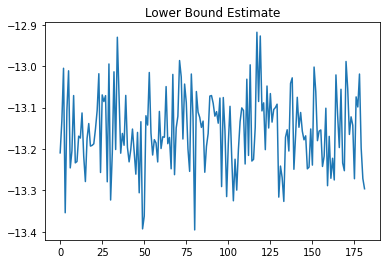

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

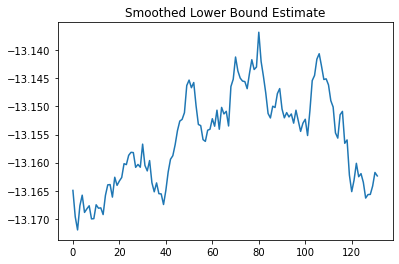

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_mu = best_lambda[0]

best_l = np.zeros((4, 4))
best_l[:, 0] = best_lambda[1][0:4]
best_l[1:4, 1] = best_lambda[1][4:7]
best_l[2:4, 2] = best_lambda[1][7:9]
best_l[3:4, 3] = best_lambda[1][9:10]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.51972423,  0.04640442,  1.14521122, -0.13415417])

Text(0.5, 1.0, 'Posterior density of alpha')

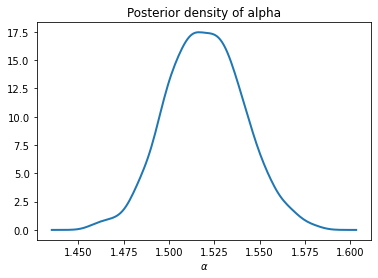

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)
kde = gaussian_kde(best_alpha)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

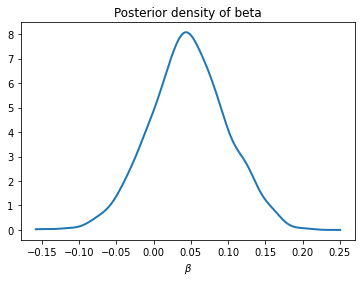

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde = gaussian_kde(best_beta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

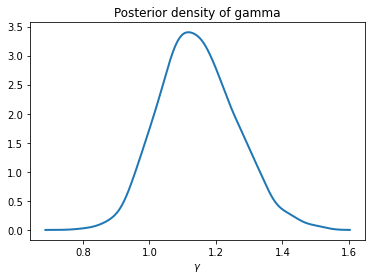

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
kde = gaussian_kde(best_gamma)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

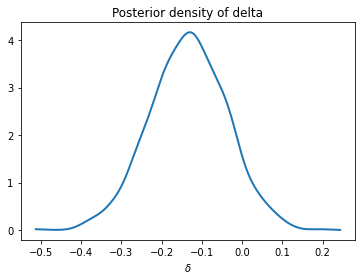

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.001)
kde = gaussian_kde(best_delta)
y_plot = kde(x_plot)
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')